# Image Retrieval using Embeddings from a Classifier and a Nearest Neighbour search (CIFAR-10)

## Imports

In [2]:
%pip install numpy torch torchvision matplotlib tqdm pillow seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from operator import itemgetter
from PIL import Image
from seaborn import heatmap

### Enable CUDA

In [4]:
device = torch.device("cuda") \
    if torch.cuda.is_available() \
    else torch.device("cpu")
    
print(f"Device: {device}")

Device: cuda


## Dataset

### Utils

In [5]:
mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])

batch_size = 128

def get_image_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=batch_size)
    numberof_images = 0
    mean, std = 0, 0

    for batch, _ in tqdm.tqdm(loader, unit="batch"):
        batch = batch.view(batch.size(0), batch.size(1), -1)

        numberof_images += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    return mean / numberof_images, std / numberof_images

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize=False):
    x = unnormalize(x)
    
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    
    return x

def show(image, axis=None):
    numpy_image = image.cpu().numpy()
    if axis is not None:
        axis.imshow(np.transpose(numpy_image, (1,2,0)))
    else:
        plt.imshow(np.transpose(numpy_image, (1,2,0)))

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)                   
])

### Load ShapeNet (smaller version for this task)

In [6]:
cifar10_train = datasets.CIFAR10("./data/", train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10("./data/", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
mean, std = get_image_mean_and_std(cifar10_train)
print(f"Mean: {mean}\nStd. Deviation: {std}")

100%|██████████| 391/391 [00:08<00:00, 45.55batch/s]

Mean: tensor([-1.2805e-06, -1.7110e-04,  1.1846e-04])
Std. Deviation: tensor([0.8190, 0.8206, 0.7700])


### Shuffling and Splitting Dataset

In [8]:
loader_train = DataLoader(cifar10_train, batch_size=batch_size)

[test, validation, db] = random_split(cifar10_test, (2000, 500, 7500))

print(f"Dataset Lengths:"
      f"\n\tTrain: {len(cifar10_train)},"
      f"\n\tTest: {len(test)},"
      f"\n\tDatabase: {len(db)}")

loader_test = DataLoader(test, batch_size=batch_size)
loader_database = DataLoader(db, batch_size=batch_size)

Dataset Lengths:
	Train: 50000,
	Test: 2000,
	Database: 8000


## Model

In [22]:
class ClassifierModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.fc_size = 512

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=256,
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 8 x 8 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,
                      out_channels=self.fc_size,
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 4 x 4 x 512
            nn.BatchNorm2d(self.fc_size),
            nn.AvgPool2d(4), # 1 x 1 x 512
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Linear(in_features=self.fc_size, 
                                    out_features=num_classes)
        
    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)
    
    def forward(self, x):
        embedding = self.encode(x)
        return self.classifier(embedding)


## Search Algorithm

In [35]:
def cosine_similarity(a: np.ndarray, b: np.ndarray):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def similarity_metric(target, embedding):
    vector, label, path = embedding
    return cosine_similarity(target, vector), label, path

def get_similarities(target_image, embeddings, pca=None):
    target_image_transformed = target_image.unsqueeze(0).to(device)
    embedding = model.encode(target_image_transformed)
    target_embedding = embedding.squeeze(0).cpu().detach().numpy()
    #target_embedding = pca.transform(target_embedding)
    
    similarity = map(lambda x: similarity_metric(target_embedding, x), embeddings)
    return sorted(similarity, key=itemgetter(0), reverse=True)

def get_closest_match(target_image, embeddings):
    return get_similarities(target_image, embeddings)[0]

## Training

### Hyperparameters

In [24]:
num_epochs = 30
learning_rate = 5e-4
batch_size = 128
image_size = 32
weight_decay = 1e-9

num_classes = len(cifar10_train.classes)

### Initialisation

In [25]:
model = ClassifierModel(num_classes).to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay)

### Sample Data

Dimensions of a batch: torch.Size([128, 3, 32, 32])


/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


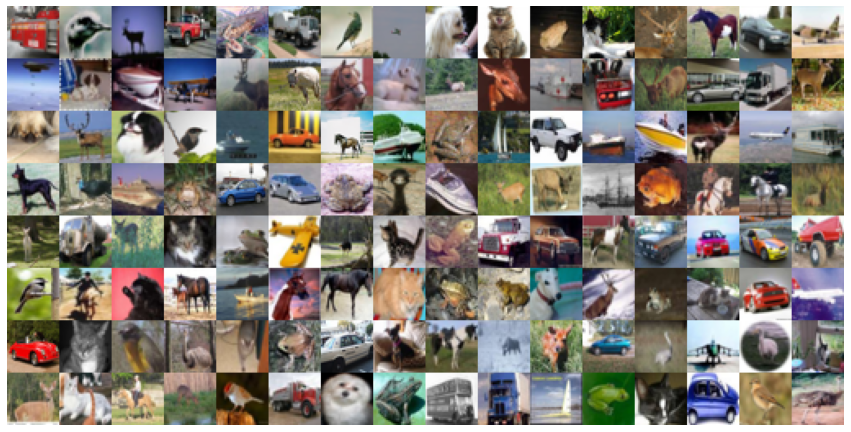

In [26]:
samples, _ = next(iter(loader_database))

print(f"Dimensions of a batch: {samples.shape}")

samples = unnormalize(samples.cpu())
samples = make_grid(samples, nrow=16, padding=0, normalize=False,
                    range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(samples)

### Training Loop

In [28]:
training_losses = list()

model.train()

for epoch in range(num_epochs):
	epoch_loss = 0
	num_batches = 0

	with tqdm.tqdm(loader_train, unit="batch") as tepoch:
		tepoch.set_description(f"Epoch {epoch+1}")

		for i, (images, labels) in enumerate(tepoch):   
			optimiser.zero_grad()
			images = images.to(device)
			labels = labels.to(device)

			predictions = model(images)
			loss = F.cross_entropy(predictions, labels)

			loss.backward()
			optimiser.step()

			epoch_loss += loss.item()
			num_batches += 1

			training_loss = loss.item() / len(images)
			tepoch.set_postfix(loss=training_loss)

	training_losses.append(epoch_loss / num_batches)

Epoch 30: 100%|██████████| 391/391 [00:08<00:00, 44.59batch/s, loss=0.000429]


## Evaluation

In [29]:
model.eval()

ClassifierModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (9): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)

### Reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dimensions of a batch: (128, 3, 32, 32)


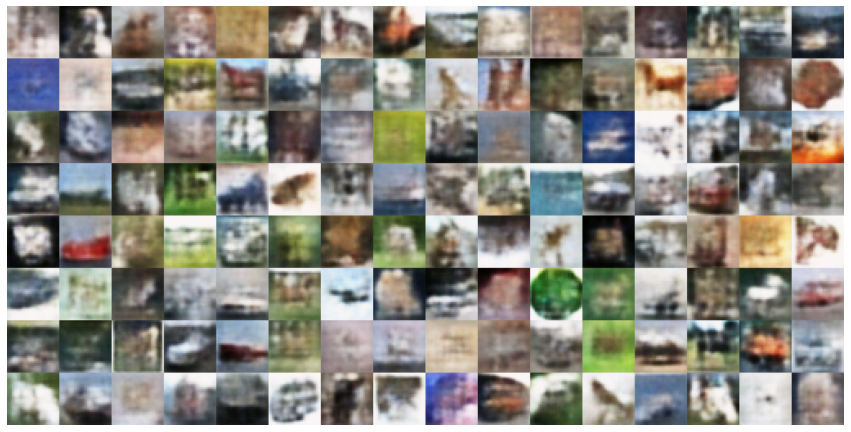

In [ ]:
samples, _ = next(iter(loader_database))

print(f"Dimensions of a batch: {tuple(samples.shape)}")

reconstruction, _, _ = model(samples.to(device))
reconstruction = unnormalize(reconstruction.cpu())

reconstruction = make_grid(reconstruction, nrow=16, padding=0, 
                           normalize=False, range=None, 
                           scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(reconstruction)

### t-SNE Plot

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


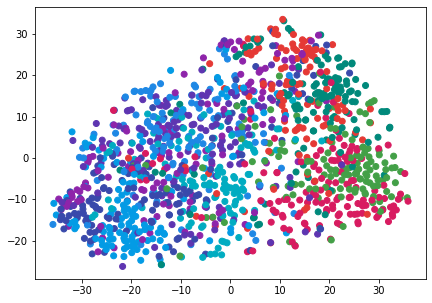

In [31]:
label_colour_lookup = [
    "#E53935", # planes
    "#D81B60", # benches
    "#8E24AA", # cupboards/wardrobes
    "#5E35B1", # cars
    "#3949AB", # chairs
    "#1E88E5", # computers
    "#039BE5", # lamps
    "#00ACC1", # speakers
    "#00897B", # guns
    "#43A047", # sofas
    "#FF7F50", # tables/desks
    "#9FE2BF", # phones
    "#CCCCFF"  # boats
]

batches = list()
z_colours = list()

batch_iterable = iter(loader_database)

for _ in range(10):
    images, labels = next(batch_iterable)
    embedding = model.encode(images.to(device))
    z = embedding.cpu().detach().numpy()

    z_colours.extend(list(map(lambda x: label_colour_lookup[int(x)], labels)))

    batches.append(z)

z = np.vstack(tuple(batches))

z_reduced = TSNE(init="pca", learning_rate="auto").fit_transform(z)
z_reduced_x, z_reduced_y = zip(*z_reduced)

figure, axis = plt.subplots()
figure.set_size_inches(7, 5)

axis.scatter(list(z_reduced_x), list(z_reduced_y), c=z_colours)

## Query Test

### Create Embeddings Database

In [32]:
embeddings_database = list()

for images, labels in tqdm.tqdm(loader_database, unit="batch"):
    embeddings = model.encode(images.to(device)).cpu().detach().numpy()
    images = images.detach().numpy()
    labels = labels.numpy()
    embeddings_database.extend(list(zip(embeddings, labels, images)))

100%|██████████| 63/63 [00:01<00:00, 49.19batch/s]


In [33]:
test_embedding, test_label, test_image = embeddings_database[0]
print(test_embedding.shape, test_label, test_image.shape)

(512,) 9 (3, 32, 32)


### Run Query

Target Image (2)
Similarity (closest image 1): 0.8093 (2)
Similarity (closest image 2): 0.7824 (6)
Similarity (closest image 3): 0.7810 (2)
Similarity (closest image 4): 0.7808 (5)
Similarity (closest image 5): 0.7737 (2)
Similarity (furthest image 1): 0.1004 (5)
Similarity (furthest image 2): 0.1000 (9)
Similarity (furthest image 3): 0.0951 (9)
Similarity (furthest image 4): 0.0936 (7)
Similarity (furthest image 5): 0.0895 (4)


/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


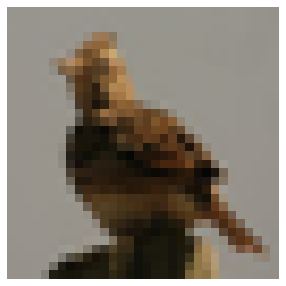

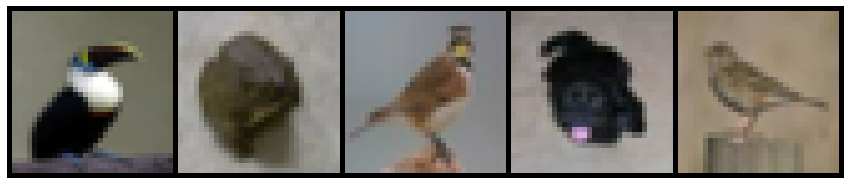

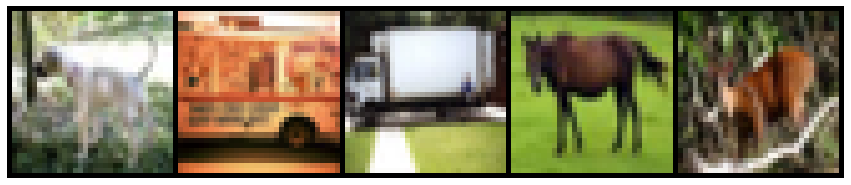

In [36]:
target, label = random.choice(loader_test.dataset)
results = get_similarities(target, embeddings_database)

figure, axis = plt.subplots()
figure.set_size_inches(5, 5)
axis.set_axis_off()

print(f"Target Image ({label})")

show(unnormalize(target), axis=axis)

good_matches = list()

for i, (similarity, label, image) in enumerate(results[:5]):
    print(f"Similarity (closest image {i+1}): {similarity:.4f} ({label})")

    image = unnormalize(torch.tensor(image).unsqueeze(0))
    good_matches.append(image.cpu())

good_matches = torch.vstack(good_matches)
good_matches = make_grid(good_matches, nrow=5, padding=1, normalize=False,
                         range=None, scale_each=False, pad_value=0)

good_figure, good_axis = plt.subplots()
good_figure.set_size_inches(15, 15)
good_axis.set_axis_off()

show(good_matches, axis=good_axis)

bad_matches = list()

for i, (similarity, label, image) in enumerate(results[-5:]):
    print(f"Similarity (furthest image {i+1}): {similarity:.4f} ({label})")
    
    image = unnormalize(torch.tensor(image).unsqueeze(0))
    bad_matches.append(image.cpu())

bad_matches = torch.vstack(bad_matches)
bad_matches = make_grid(bad_matches, nrow=5, padding=1, normalize=False,
                        range=None, scale_each=False, pad_value=0)

bad_figure, bad_axis = plt.subplots()
bad_figure.set_size_inches(15, 15)
bad_axis.set_axis_off()

show(bad_matches, axis=bad_axis)

### Accuracy (using class labels)

In [37]:
def confusion(predictions, ground_truth, labels):
  cm = confusion_matrix(np.array(ground_truth), np.array(predictions), normalize='true')

  figure, axis = plt.subplots()
  heatmap(cm, annot=True, ax=axis)

  axis.set_xlabel('Predicted labels')
  axis.set_ylabel('True labels')
  axis.set_title('Confusion Matrix')

  axis.xaxis.set_ticklabels(labels, rotation=70)
  axis.yaxis.set_ticklabels(labels, rotation=0);

  figure.set_size_inches(12, 10)

  plt.show()

def check_accuracy(loader, labels):
	idx_to_class = {v: k for k, v in cifar10_test.class_to_idx.items()}

	numberof_correct = 0
	numberof_samples = 0

	loader_labels = list()
	nearest_labels = list()

	with torch.no_grad():
		for image, label in tqdm.tqdm(loader, unit="image"):
			image = image.to(device).squeeze()
			_, nearest_label, _ = get_closest_match(image, embeddings_database)
			
			numberof_correct += int(nearest_label == label)
			numberof_samples += 1
			
			loader_labels.append(idx_to_class[label])
			nearest_labels.append(idx_to_class[nearest_label])

		accuracy = numberof_correct / numberof_samples

		print(f"Got {numberof_correct} / {numberof_samples} correct ({100 * accuracy:.2f}%)")

		confusion(nearest_labels, loader_labels, labels)

100%|██████████| 2000/2000 [01:43<00:00, 19.28image/s]


Got 1027 / 2000 correct (51.35%)


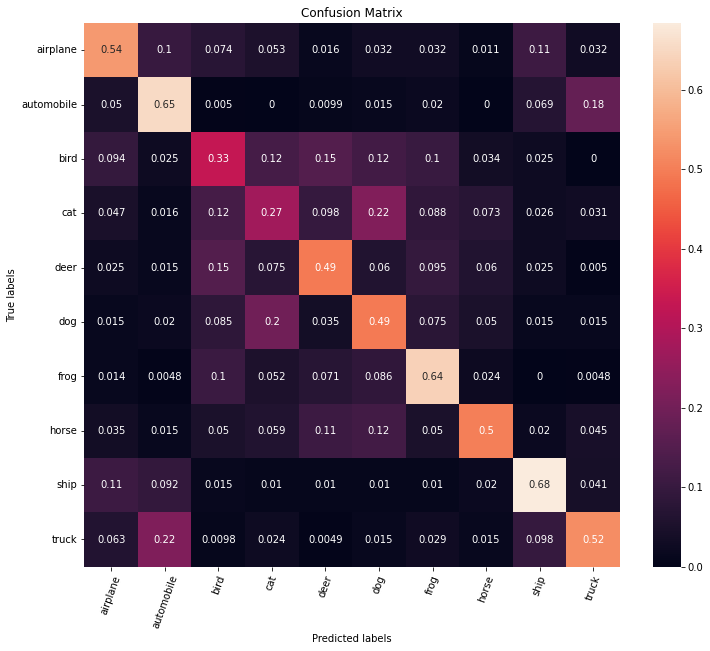

In [38]:
check_accuracy(test, cifar10_test.classes)